In [1]:
# Load the datasets

import pandas as pd 
import numpy as np 
df1=pd.read_csv('../Datasets/TMDB5000/tmdb_5000_credits.csv')
df2=pd.read_csv('../Datasets/TMDB5000/tmdb_5000_movies.csv')

C:\Users\alexw\AppData\Local\Temp\ipykernel_44000\940160150.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# This column merges the movie data using the id column as the key...We're going to call this movie_data then we are going to show 5 random results. Then removes un-released movies from the df.

df1.columns = ['id', 'tittle', 'cast', 'crew']
movie_data = df2.merge(df1, on='id')
# random_results = movie_data.sample(n=5) # print(random_results)
movie_data.head(3)  # Head presents it a little bit more nicely than using random samples...

relevant_cols = ['status', 'id', 'title', 'overview', 'genres', 'original_language', 'popularity', 'vote_average', 'keywords', 'cast', 'runtime', 'vote_count']
tmdb_5000_data = movie_data[relevant_cols]

dropped_movies = tmdb_5000_data[tmdb_5000_data['status'] != 'Released']
print("Movies still in pre-release form: ")
print(dropped_movies['title'])

# Drop rows with status other than 'Released'
tmdb_5000_data = tmdb_5000_data[tmdb_5000_data['status'] == 'Released']
tmdb_5000_data = tmdb_5000_data.drop('status', axis=1)

# Weighted vote score
def calculate_weighted_rating(tmdb_5000_data):
    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        m = tmdb_5000_data['vote_count'].mean()
        C = tmdb_5000_data['vote_average'].mean()
        # Calculation based on the IMDB formula
        return (v / (v + m) * R) + (m / (m + v) * C)

    # Define a new feature 'weighted_score' and calculate its value with `weighted_rating()`
    tmdb_5000_data['weighted_score'] = tmdb_5000_data.apply(weighted_rating, axis=1)

calculate_weighted_rating(tmdb_5000_data)

# Drop 'vote_count' and 'vote_average' columns because they are no longer needed...
tmdb_5000_data = tmdb_5000_data.drop(['vote_count', 'vote_average'], axis=1)

# Sort movies based on 'weighted_score', not necessary right now...
# tmdb_5000_data = tmdb_5000_data.sort_values('weighted_score', ascending=False)

# Print the top 10 movies
tmdb_5000_data[['title', 'weighted_score']].head(10)

tmdb_5000_data.head(3)
tmdb_5000_data.to_csv('csv/tmdb_5000_data.csv', index=False)

# So now the movie datasets have been combined...and unreleased movies have been dropped from the set

Movies still in pre-release form: 
2906             Dancin' It's On
4169              Brotherly Love
4178               Higher Ground
4401         The Helix... Loaded
4453        Crying with Laughter
4508    The Harvest (La Cosecha)
4662              Little Big Top
4754               The Naked Ape
Name: title, dtype: object


In [3]:
print(movie_data.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'tittle', 'cast', 'crew'],
      dtype='object')


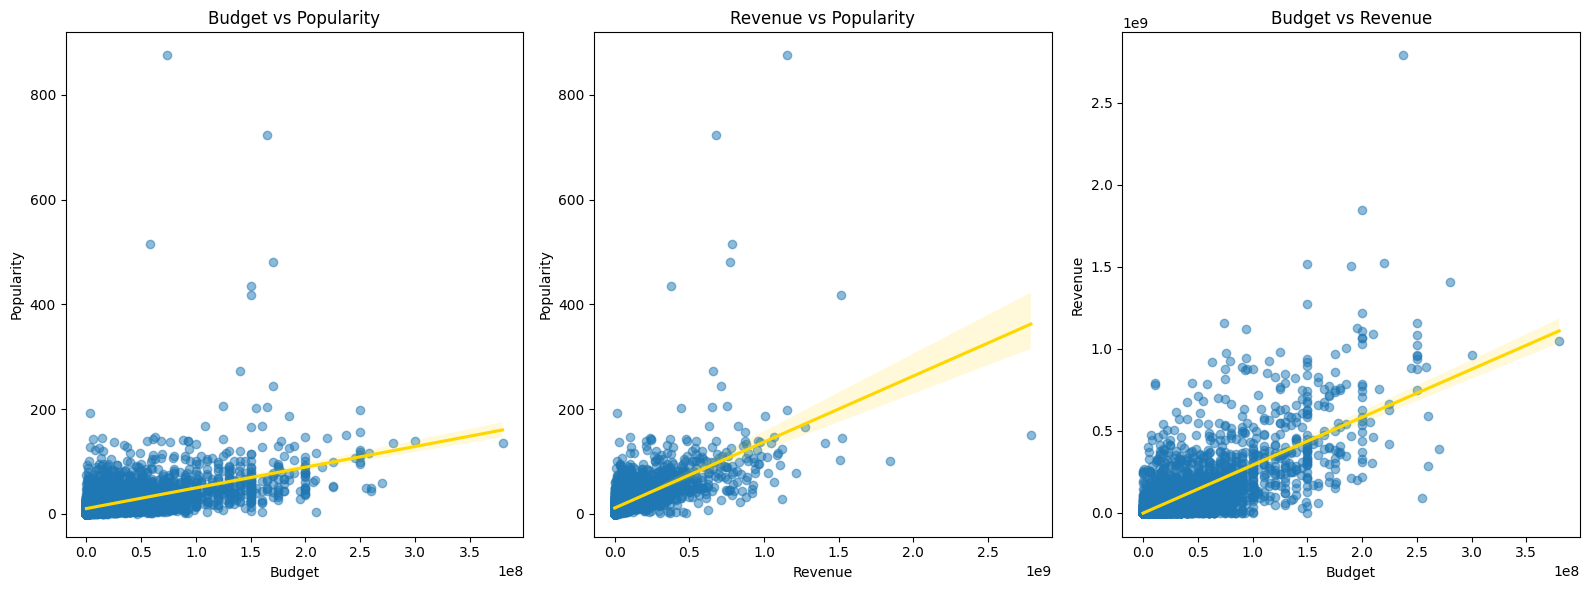

In [4]:
# Represents budget vs revenue vs popularity.

import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing values in 'budget', 'popularity', and 'revenue' columns
movie_data.dropna(subset=['budget', 'popularity', 'revenue'], inplace=True)

# Define color
line_color = '#FFD700'  # Darkish yellow color

# Plotting Budget vs Popularity
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
sns.regplot(data=movie_data, x='budget', y='popularity', scatter_kws={"alpha":0.5}, line_kws={"color": line_color})
plt.title('Budget vs Popularity')
plt.xlabel('Budget')
plt.ylabel('Popularity')

# Plotting Revenue vs Popularity
plt.subplot(1, 3, 2)
sns.regplot(data=movie_data, x='revenue', y='popularity', scatter_kws={"alpha":0.5}, line_kws={"color": line_color})
plt.title('Revenue vs Popularity')
plt.xlabel('Revenue')
plt.ylabel('Popularity')


# Plotting Revenue vs Popularity
plt.subplot(1, 3, 3)
sns.regplot(data=movie_data, x='budget', y='revenue', scatter_kws={"alpha":0.5}, line_kws={"color": line_color})
plt.title('Budget vs Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')


plt.tight_layout()
plt.show()


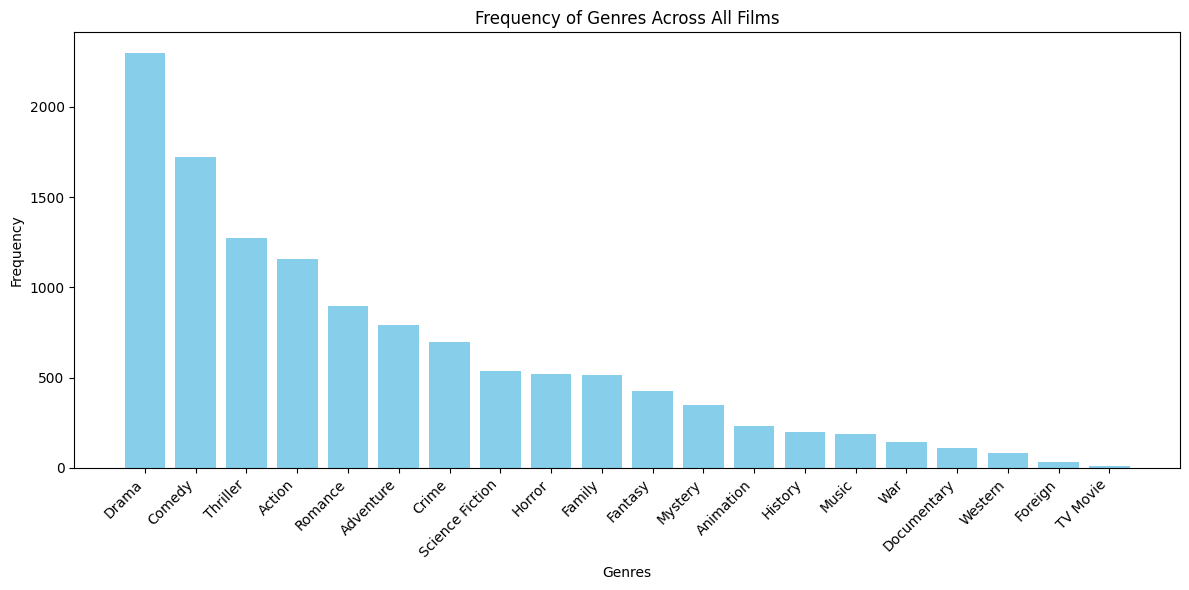

In [5]:
# Represents the frequency of each unique genre

import pandas as pd
import matplotlib.pyplot as plt

# Extract genres and convert them into a list
genres_list = movie_data["genres"].apply(lambda x: [genre["name"] for genre in eval(x)])
genres_list = [genre for sublist in genres_list for genre in sublist]

# Create a dictionary to store the frequency of each genre
genre_counts = {}
for genre in genres_list:
    if genre in genre_counts:
        genre_counts[genre] += 1
    else:
        genre_counts[genre] = 1

# Convert the dictionary to a DataFrame for easier manipulation
genre_counts_df = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Frequency'])

# Sort the DataFrame by frequency
genre_counts_df = genre_counts_df.sort_values(by='Frequency', ascending=False)

# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar(genre_counts_df['Genre'], genre_counts_df['Frequency'], color='skyblue')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Frequency of Genres Across All Films')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [6]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
tmdb_5000_data['overview'] = tmdb_5000_data['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(tmdb_5000_data['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4795, 20970)

In [7]:
# Content based recommendation model using cosine similarity to find similar movies.

# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse map of indices and movie titles
indices = pd.Series(tmdb_5000_data.index, index=tmdb_5000_data['title']).drop_duplicates()

# Function that takes in movie title as input and outputs most similar movies
def get_cosine_recommendations(title, cosine_sim=cosine_sim, tmdb_5000_data=tmdb_5000_data):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Get the titles and overviews of the top 10 most similar movies
    recommended_movies = tmdb_5000_data.iloc[movie_indices][['title', 'overview']]

    return recommended_movies



In [11]:
get_cosine_recommendations('The Avengers')

,title,overview
7,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...
3144,Plastic,Sam &amp; Fordy run a credit card fraud scheme...
1715,Timecop,An officer for a security agency that regulate...
4124,This Thing of Ours,"Using the Internet and global satellites, a gr..."
3311,Thank You for Smoking,The chief spokesperson and lobbyist Nick Naylo...
3033,The Corruptor,"Danny is a young cop partnered with Nick, a se..."
588,Wall Street: Money Never Sleeps,As the global economy teeters on the brink of ...
2136,Team America: World Police,Team America World Police follows an internati...
1468,The Fountain,"Spanning over one thousand years, and three pa..."
1286,Snowpiercer,In a future where a failed global-warming expe...


In [15]:
get_cosine_recommendations('Toy Story 2')

,title,overview
1541,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
42,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven..."
1779,The 40 Year Old Virgin,Andy Stitzer has a pleasant life with a nice a...
1191,Small Soldiers,When missile technology is used to enhance toy...
2569,Match Point,Match Point is Woody Allen’s satire of the Bri...
4387,A LEGO Brickumentary,A look at the global culture and appeal of the...
3873,Class of 1984,Andy is a new teacher at a inner city high sch...
2303,The Nutcracker,"On Christmas Eve, a little girl named Marie (C..."
3170,Down to You,"College coeds in New York City, Al, the son of..."
3379,Factory Girl,"In the mid-1960s, wealthy debutant Edie Sedgwi..."
